In [1]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler

#x = [T_m, T_c]
#u = [Q_in, T_env]
#theta = [C_m, C_c, hA_m2c, hA_m2env, hA_eff, mda]
chp_air = 1000 #J/kg/K

def RK4_solver(f, x0, t0, t1, N, u, theta):
    dt = (t1-t0)/N
    t = np.linspace(t0, t1, N)
    x_solved = np.zeros((N+1, len(x0)))
    dx_solved = np.zeros((N, len(x0)))
    x_solved[0] = x0
    for i in range(N): 
        K1 = f(x_solved[i], u[i], theta) #Make sure f returns an array of shape (2,)
        K2 = f(x_solved[i]+K1/2, u[i], theta)
        K3 = f(x_solved[i]+K2/2, u[i], theta)
        K4 = f(x_solved[i]+K3, u[i], theta)
        K = K1/6 + K2/3 + K3/3 + K4/6
        x_solved[i+1] = x_solved[i] + K*dt
        dx_solved[i] = K
    return x_solved[:-1], dx_solved

def dxdt(x, u, theta): 
    Q_HE = theta[5]*chp_air*(1-np.exp(-theta[4]/(theta[5]*chp_air)))*(x[1]-u[1])
    dTm_dt = (u[0]-theta[2]*(x[0]-x[1])-theta[3]*(x[0]-u[1]))/theta[0]
    dTc_dt = (theta[2]*(x[0]-x[1])-Q_HE)/theta[1]
    return np.array([dTm_dt, dTc_dt])

def find_input_vals(u_range, N, change=0.01):
    #u_range = [(u1_min, u1_max), (u2_min, u2_max)]
    u1 = np.zeros(N)
    u2 = np.zeros(N)
    u1_rand = np.random.uniform(u_range[0][0], u_range[0][1])
    u2_rand = np.random.uniform(u_range[1][0], u_range[1][1])
    for i in range(0, N): 
        ch = np.random.uniform(0, 1)
        u1[i] = u1_rand
        u2[i] = u2_rand
        if ch < change: 
            u1_rand = np.random.uniform(u_range[0][0], u_range[0][1])
            #u2_rand = np.random.uniform(u_range[1][0], u_range[1][1])
            
    return np.array([u1, u2]).T
    


In [2]:
t0 = 0 
t1 = 200 #s 
N = 2000
jump_el = 20 #How many steps before storing a value as NN input
t = np.linspace(t0, t1, N)

N_tot_points = 50000
N_sim = int(N_tot_points/(N/jump_el))
print("Total datapoints should end up being: {}, with {} simulations.".format(int(N/jump_el)*N_sim, N_sim))


x0_range = [(10, 70), (10, 70)] #T_m0 = T_c0
u_range = [(0, 30), (10, 30)]
theta_range = [(100, 800), (40, 400), (5,20), (0.1,1), (1,5), (0.3, 1.2)]

X_NN = np.zeros((N_sim*int(N/jump_el), 8)) #NN 8 inputs: [x1, x1, dx1, dx2, u1, u2, Cm, Cc]
y_NN = np.zeros((N_sim*int(N/jump_el), 6)) #NN 6 outputs (all parameters also considering Cm and Cc)

for i in range(N_sim): 
    if i % 100 == 0: 
        print("Simulation number ", i)
    theta = np.array([np.random.uniform(th[0], th[1]) for th in theta_range])
    #Find two values to oscillate between for inputs    
    x0 = np.array([0,0])
    x0[0] = np.random.uniform(x0_range[0][0], x0_range[0][1])
    x0[1] = x0[0] + np.random.normal(5)
    u_in = find_input_vals(u_range, N, change=0.005)
    x_sol, dx_sol = RK4_solver(dxdt, x0, t0, t1, N, u_in, theta)
    
    #Storing values in arrays
    x_sol = x_sol[::jump_el]
    dx_sol = dx_sol[::jump_el]
    u_in = u_in[::jump_el]
    j = 0
    for x, dx, u in zip(x_sol, dx_sol, u_in): 
        X_NN[i*len(x_sol)-1+j][0] = x[0]
        X_NN[i*len(x_sol)-1+j][1] = x[1]
        X_NN[i*len(x_sol)-1+j][2] = dx[0]
        X_NN[i*len(x_sol)-1+j][3] = dx[1]
        X_NN[i*len(x_sol)-1+j][4] = u[0]
        X_NN[i*len(x_sol)-1+j][5] = u[1]
        X_NN[i*len(x_sol)-1+j][6] = theta[0]
        X_NN[i*len(x_sol)-1+j][7] = theta[1]
        
        y_NN[i*len(x_sol)-1+j][0] = theta[0]
        y_NN[i*len(x_sol)-1+j][1] = theta[1]
        y_NN[i*len(x_sol)-1+j][2] = theta[2]
        y_NN[i*len(x_sol)-1+j][3] = theta[3]
        y_NN[i*len(x_sol)-1+j][4] = theta[4]
        y_NN[i*len(x_sol)-1+j][5] = theta[5]
        j += 1
        
print("X_shape: {}, y_shape: {}".format(X_NN.shape, y_NN.shape))

Total datapoints should end up being: 50000, with 500 simulations.
Simulation number  0
Simulation number  100
Simulation number  200
Simulation number  300
Simulation number  400
X_shape: (50000, 8), y_shape: (50000, 6)


In [5]:
np.save("X_NN", X_NN)
np.save("y_NN", y_NN)

In [361]:
X_NN_loaded = np.load("X_NN_case1.npy")
y_NN_loaded = np.load("y_NN_case1.npy")

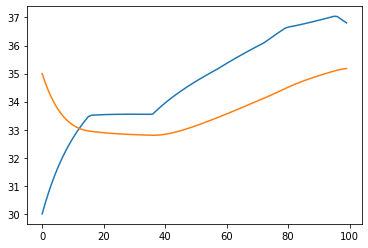

In [6]:
plt.plot(x_sol)
plt.show()

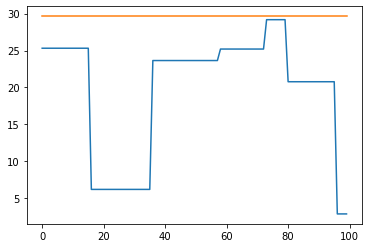

In [7]:
plt.plot(u_in)

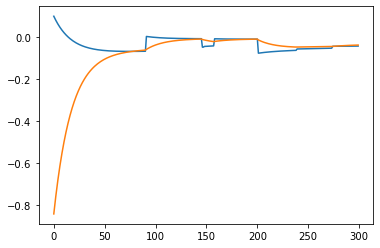

In [80]:
plt.plot(dx_sol)